In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')
display(df.head())

,Date,Price
0,1/9/2025 0:00,0.185
1,1/10/2025 0:00,0.185
2,1/11/2025 0:00,0.195
3,1/12/2025 0:00,0.195
4,1/13/2025 0:00,0.195


In [7]:
data = df.Price

Optimizing bandwidth using vectorized cross-validation...
Optimal bandwidth found: 0.3692 (took 0.3387s)
Using Scott's rule for bandwidth...
Bandwidth (Scott's rule): 0.8409 (took 0.0001s)


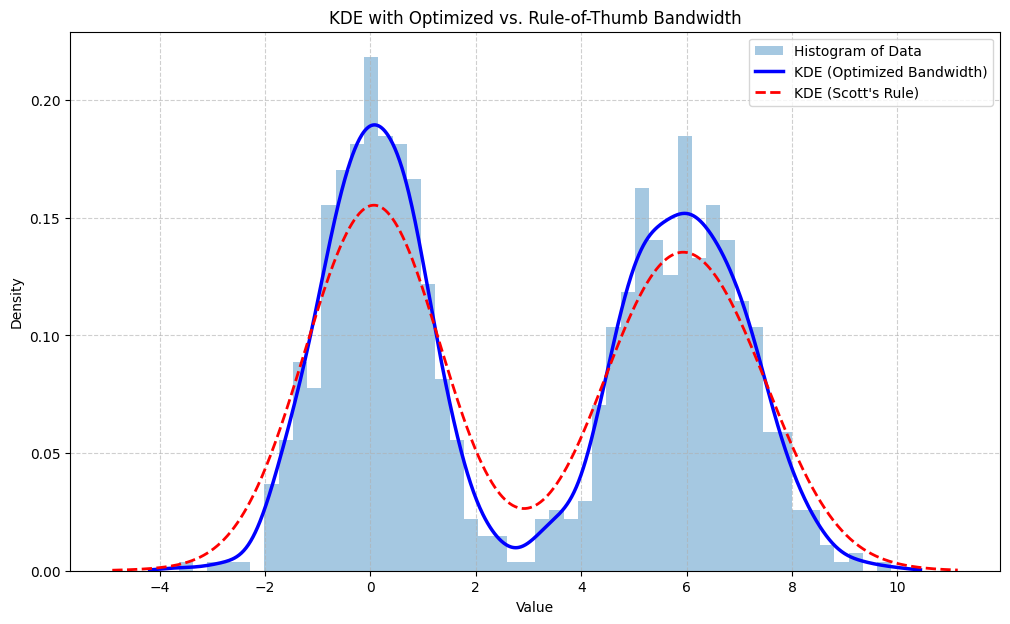

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import time

def _optimize_bandwidth_cv_vectorized(data):
    """
    Finds the optimal bandwidth for KDE using a vectorized (fast) implementation
    of leave-one-out cross-validation.

    Args:
        data (np.array): The input data vector.

    Returns:
        float: The optimal bandwidth.
    """
    n = len(data)

    def cross_validation_loss(bandwidth):
        """
        Calculates the cross-validation loss (negative log-likelihood) for a given bandwidth.
        This function is vectorized for performance.
        """
        # Create an n x n matrix of pairwise density evaluations in one go.
        # densities[i, j] corresponds to the kernel evaluated at data[i] centered at data[j].
        densities = norm.pdf(data[:, np.newaxis], loc=data, scale=bandwidth)

        # The sum of densities for each point `i` from all other points `j`
        # is the sum of the i-th row, minus the diagonal element (where j==i).
        row_sums = np.sum(densities, axis=1)
        diagonal_elements = np.diag(densities)

        # Calculate the leave-one-out density estimate at each point.
        loo_densities = (row_sums - diagonal_elements) / (n - 1)

        # To avoid log(0), replace zero or negative densities with a tiny positive number.
        loo_densities[loo_densities <= 0] = 1e-9

        # Calculate the total log-likelihood. We want to maximize this.
        log_likelihood = np.sum(np.log(loo_densities))

        # The optimizer minimizes, so we return the negative log-likelihood.
        return -log_likelihood

    # Use a numerical optimizer to find the bandwidth that minimizes the loss.
    # We provide bounds to guide the optimizer. A reasonable upper bound is the data's std dev.
    std_dev = np.std(data) if np.std(data) > 0 else 1.0
    result = minimize_scalar(
        cross_validation_loss,
        bounds=(std_dev / 100, std_dev * 2),
        method='bounded'
    )

    return result.x


def kernel_density_estimation(vector, grid_points=1000, bandwidth_method='cv'):
    """
    Estimates the density of a vector using Kernel Density Estimation (KDE).

    Args:
        vector (list or np.array): The input vector of numerical data.
        grid_points (int): The number of points to use for the density plot.
        bandwidth_method (str): 'cv' for cross-validation (recommended) or
                                'scott' for Scott's rule of thumb.

    Returns:
        tuple: A tuple containing:
            - x_grid (np.array): The x-values for the density plot.
            - density_estimate (np.array): The estimated density values.
    """
    # --- 1. Data Preparation ---
    data = np.array(vector)
    n = len(data)
    if n == 0:
        raise ValueError("Input vector cannot be empty.")

    # --- 2. Bandwidth Selection ---
    start_time = time.time()
    if bandwidth_method == 'cv':
        print("Optimizing bandwidth using vectorized cross-validation...")
        bandwidth = _optimize_bandwidth_cv_vectorized(data)
        elapsed = time.time() - start_time
        print(f"Optimal bandwidth found: {bandwidth:.4f} (took {elapsed:.4f}s)")
    elif bandwidth_method == 'scott':
        print("Using Scott's rule for bandwidth...")
        std_dev = np.std(data)
        if std_dev == 0: std_dev = 1
        bandwidth = 1.06 * std_dev * (n ** (-1/5))
        elapsed = time.time() - start_time
        print(f"Bandwidth (Scott's rule): {bandwidth:.4f} (took {elapsed:.4f}s)")
    else:
        raise ValueError("Invalid bandwidth_method. Choose 'cv' or 'scott'.")

    if bandwidth <= 0:
        print("Warning: Calculated bandwidth is zero or negative. Using a small default.")
        bandwidth = 0.1

    # --- 3. Set up the Grid for Plotting ---
    x_min, x_max = np.min(data), np.max(data)
    padding = 1.5 * bandwidth
    x_grid = np.linspace(x_min - padding, x_max + padding, grid_points)

    # --- 4. Kernel Density Estimation (Vectorized) ---
    # This vectorized version is faster than iterating through the data points.
    # It computes all kernel values at once and sums them up.
    density_estimate = np.sum(norm.pdf(x_grid[:, np.newaxis], loc=data, scale=bandwidth), axis=1)
    density_estimate /= n

    return x_grid, density_estimate

if __name__ == '__main__':
    # --- Example Usage ---

    # 1. A bimodal distribution with a larger dataset to see the performance gain
    sample_vector = np.concatenate([
        np.random.normal(0, 1, 500),
        np.random.normal(6, 1.2, 500)
    ])

    try:
        # 2. Estimate the density using the optimized bandwidth
        x_cv, y_cv = kernel_density_estimation(sample_vector, bandwidth_method='cv')
        # For comparison, let's also see the rule-of-thumb estimate
        x_scott, y_scott = kernel_density_estimation(sample_vector, bandwidth_method='scott')

        # 3. Plot the results
        plt.figure(figsize=(12, 7))
        plt.hist(sample_vector, bins=50, density=True, alpha=0.4, label='Histogram of Data')
        plt.plot(x_cv, y_cv, color='blue', lw=2.5, label='KDE (Optimized Bandwidth)')
        plt.plot(x_scott, y_scott, color='red', lw=2, linestyle='--', label='KDE (Scott\'s Rule)')
        plt.title('KDE with Optimized vs. Rule-of-Thumb Bandwidth')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    except ValueError as e:
        print(f"Error: {e}")
